In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import os
from scipy.stats.mstats import winsorize
from tqdm import tqdm
import seaborn as sns
import sklearn
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier,XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import  train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn import svm
from scipy import interp
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from torchvision import datasets
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["font.sans-serif"]="Times New Roman"

D:\Applications\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
D:\Applications\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
# 读取数据
train_data=pd.read_csv(r"Dataset/cs-training.csv",index_col="Unnamed: 0")
test_data=pd.read_csv(r"Dataset/cs-test.csv",index_col="Unnamed: 0")
column_names=["Default","Balance_r","Age","Worse_1m", "Debt_r","Income","Credit_num","Worse_3m","Estate_num","Worse_2m","Family_num"]
train_data.columns=column_names
test_data.columns=column_names
train_data=train_data[~(train_data["Balance_r"]>1)]
train_data = train_data[~(train_data["Age"]<20)]
skew =train_data.skew().sort_values(ascending =False )
skew_df= pd.DataFrame({'skew':skew})
skew_index=skew_df[skew_df>10].dropna().index
log_data=np.log(train_data[skew_index]+1)
train_data1=train_data.copy()
train_data1[skew_index]=log_data
for name in column_names:
    train_data1[name]=winsorize(train_data1[name], limits=[0.005,0.005],nan_policy="omit")

# 特征提取


# 预测部分

## 准备工作
### 对test的数据处理
考虑到之前我们对train样本做了一定的处理, 我们必须对test的样本也做相同的处理. 不同于train_data, 对于明显有错误的值, 我们不能直接删除, 而是要将其转化为缺失值.

In [3]:
tmp_balance=test_data["Balance_r"].copy()
tmp_balance[tmp_balance>1]=np.nan
test_data["Balance_r"]=tmp_balance # 将Balance_r超过1的重新设为np.nan
test_data[skew_index]=np.log(test_data[skew_index]+1)
max_value=train_data1.max()
for name, value in max_value[1:].iteritems():
    tmp=test_data[name].copy()
    tmp[tmp>value]=value
    test_data[name]=tmp

In [4]:
y_train=train_data1["Default"]
X_train=train_data1.drop(['Default'], axis=1)
X_test=test_data.drop(['Default'], axis=1)

### 缺失值填充
为了最大限度地使用训练样本, 我们选择填充缺失值而不是将缺失值所在的行直接删去. 当某一个元素缺失时, 我们通过其所在行其他列上的数据来预测缺失值的值. 这里采用了xgboost方法

In [5]:
def fillna_XGB(label):
    xgbr=XGBRegressor()
    nn_data=X_train[~X_train[label].isnull()].copy()
    y_=nn_data[label]
    X_=nn_data.drop(label,axis=1)
    xgbr.fit(X_,y_)
    train_X_missing=X_train[X_train[label].isnull()].drop([label],axis=1)
    test_X_missing=X_test[X_test[label].isnull()].drop([label],axis=1)
    train_y_pred=xgbr.predict(train_X_missing)
    test_y_pred=xgbr.predict(test_X_missing)
    if X_train[label].isnull().any():
        X_train.loc[(X_train[label].isnull()), label]=train_y_pred
    if X_test[label].isnull().any():
        X_test.loc[(X_test[label].isnull()), label]=test_y_pred
fillna_XGB("Income")
fillna_XGB("Family_num")
fillna_XGB("Balance_r")

### 划分训练集和验证集
为了避免过拟合, 我们不直接使用test data, 而是选择将训练集划分为一个训练集和一个验证集, 这里确定一个随机数种子以保证后续分析的相同的数据.

我们必须注意label有偏的情况, 在后面的工作中, 我们尽量使用imblearn方法

In [6]:
X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = 2022)

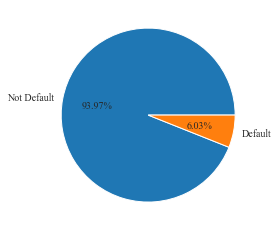

In [7]:
plt.pie([(y_training==0).sum(),(y_training!=0).sum()], labels=["Not Default","Default"], autopct='%.2f%%')
plt.show()

In [8]:
smo = SMOTE()
X_training, y_training = smo.fit_resample(X_training, y_training)

### 可视化函数

In [11]:
# ROC曲线
def AUC_ROC(X,model):
    # 设置图形大小
    fig = plt.figure(figsize=(14, 10))

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    # 计算 预测率
    probas = model.predict_proba(X)
    # 计算 fpr,tpr
    fpr, tpr, thresholds = roc_curve(y_validation, probas[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr,  tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.5f)'
                        % ( roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')

    mean_tpr /= len(X_training)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot([0, 0, 1],
             [0, 1, 1],
             lw=2,
             linestyle=':',
             color='black',
             label='perfect performance')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False positive rate', size=15)
    plt.ylabel('True Positive Rate', size=15)
    plt.title('ROC-AUC Plot', size=20)
    plt.legend(loc="lower right")
    plt.show()

# 混淆矩阵
def confusion(X, model):
    y_pred=model.predict(X)
    confmat = confusion_matrix(y_true=y_validation, y_pred=y_pred)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

## 线性模型构建
### Logistic 回归
首先先使用线性Logistic分类器

Training accuracy: 0.7698203754184848
Test accuracy: 0.9409144623216071
Test F1: 0.21657088122605364


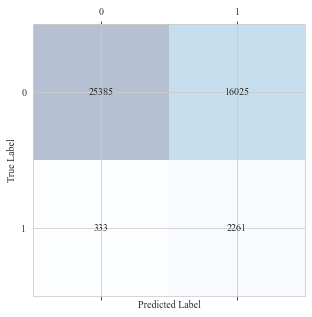

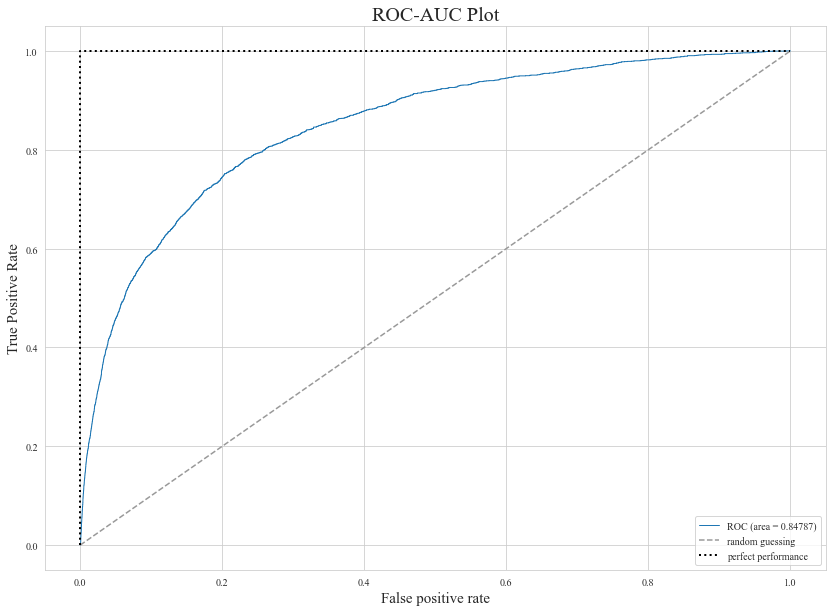

In [173]:
stdsc=StandardScaler()
X_training_std=stdsc.fit_transform(X_training)
X_validation_std=stdsc.fit_transform(X_validation)
lr=LogisticRegression()
lr.fit(X_training_std,y_training)
print('Training accuracy:', lr.score(X_training_std, y_training))
print('Test accuracy:', lr.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,lr.predict(X_validation_std)))
confusion(X_validation_std, lr)
AUC_ROC(X_validation_std,lr)

logistic分类器的性能显然不能让我们满意, 其F1-score只有0.21. 我们下面考虑SVM分类器



### SVM
众所周知, SVM当有了核函数以后是不适合大量数据的. 我们先简单试一下线性核

Training accuracy: 0.7647208200748349
Test accuracy: 0.9409144623216071
Test F1: 0.22138984721537702


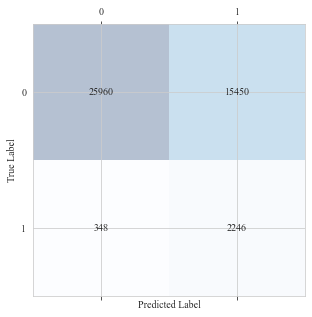

In [174]:
stdsc=StandardScaler()
X_training_std=stdsc.fit_transform(X_training)
X_validation_std=stdsc.fit_transform(X_validation)
clf= svm.LinearSVC().fit(X_training_std, y_training)
print('Training accuracy:', clf.score(X_training_std, y_training))
print('Test accuracy:', clf.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,clf.predict(X_validation_std)))
confusion(X_validation_std, clf)

从 F1 value来看, 相比于最简单的logistics回归, SVM并没有明显的优势. 事实上, 这也是可以理解的. 因为SVM在更多情况下适合样本量较小但特征很多的数据, 对于我们这里的数据集并不适用, 并且训练也会很慢. 我们可以直接排除SVM模型

## 树家族
首先我们来定义一个5-fold的验证集

In [32]:
#定义一个5-fold的集合
kf=StratifiedKFold(5, shuffle=True, random_state=2022)
train_index=[]
test_index=[]
for X_, y_  in kf.split(X_train,y_train):
    train_index.append(X_)
    test_index.append(y_)
X_train_5_old=[X_train.iloc[index] for index in train_index]
y_train_5_old=[y_train.iloc[index] for index in train_index]
X_test_5=[X_train.iloc[index] for index in test_index]
y_test_5=[y_train.iloc[index] for index in test_index]
X_train_5=[]
y_train_5=[]
smo=SMOTE(random_state=2022)
for X_, y_ in zip(X_train_5_old, y_train_5_old):
    X_, y_=smo.fit_resample(X_,y_)
    X_train_5.append(X_)
    y_train_5.append(y_)

,Balance_r,Age,Worse_1m,Debt_r,Income,Credit_num,Worse_3m,Estate_num,Worse_2m,Family_num
0,0.766127,45,1.098612,0.589442,9.118335,13,0.000000,6,0.000000,2.000000
1,0.957151,40,0.000000,0.115002,7.863651,4,0.000000,0,0.000000,1.000000
2,0.907239,49,0.693147,0.024620,11.060196,7,0.000000,1,0.000000,0.000000
3,0.213179,74,0.000000,0.318895,8.160804,3,0.000000,1,0.000000,1.000000
4,0.754464,39,0.000000,0.190571,8.160804,8,0.000000,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
220617,0.976660,28,0.785027,6.365952,0.129242,4,1.098612,0,0.000000,0.000000
220618,0.464586,49,0.000000,0.868962,8.226795,8,0.000000,1,0.000000,0.000000
220619,0.795731,47,1.098612,0.465368,8.713754,9,0.000000,2,0.179459,0.000000
220620,0.448496,48,0.800175,6.003567,0.286882,3,0.188293,0,0.000000,0.000000


In [39]:
def avg_auc(model):
    auc_list=[]
    for X_, y_, X__, y__ in zip(X_train_5,y_train_5,X_test_5,y_test_5):
        model.fit(X_,y_)
        auc=roc_auc_score(y__, model.predict_proba(X__)[:,-1])
        auc_list.append(auc)
    return np.array(auc_list)

### 随机森林
作为非常有效的手段, 让我们来使用树家族算法, 首先是随机森林. 树算法无需对数据做标准化处理

Training accuracy: 0.9997875185273479
Test accuracy: 0.924597763839651
Test F1: 0.292235494880546


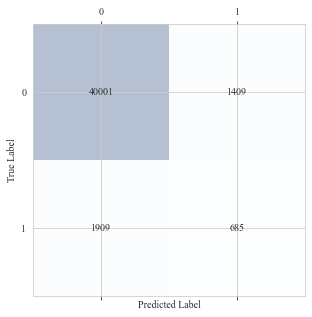

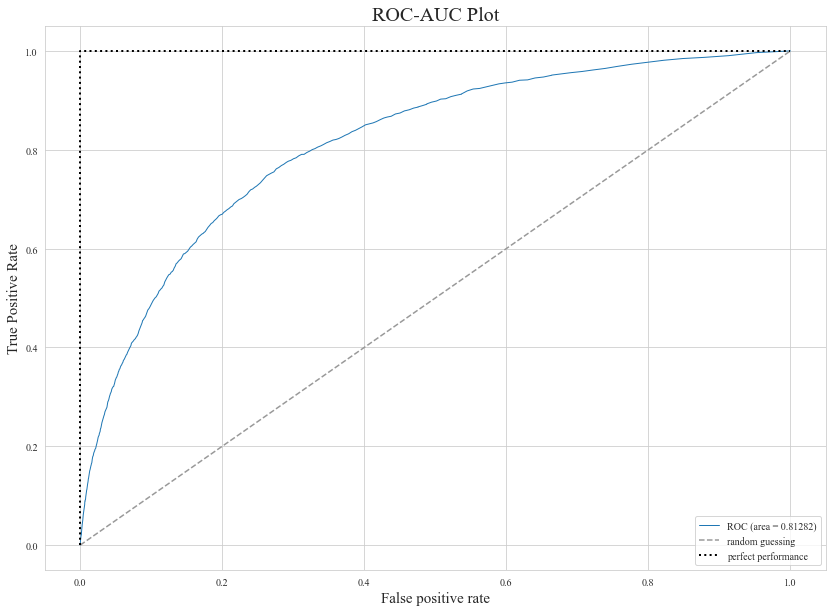

In [175]:
rfc=RandomForestClassifier(n_estimators=500, n_jobs=-1)
rfc.fit(X_training,y_training)
print('Training accuracy:', rfc.score(X_training, y_training))
print('Test accuracy:', rfc.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,rfc.predict(X_validation)))
confusion(X_validation, rfc)
AUC_ROC(X_validation,rfc)

随机森林的效度看起来变弱了, 但这很明显是因为过拟合的缘故. 我们来对超参数进行一定的搜索

100%|██████████| 6/6 [02:47<00:00, 27.84s/it]


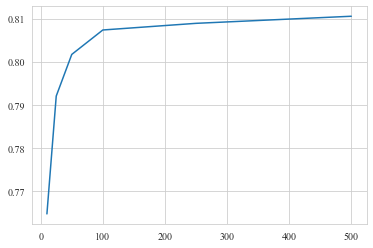

In [42]:
params_list=[10, 25, 50, 100, 250, 500]
res=[]
res_avg=[]
for params in tqdm(params_list):
    model=RandomForestClassifier(n_estimators=params, n_jobs=-1)
    tmp=avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

可以看出, 在交叉验证中, 平均auc的结果随着n_estimators的增大而不断增大. 但在100以后增加的幅度不明显. 当n_estimators越大时, 过拟合的倾向越明显, 且训练速度有所下降. 因此我们会选择一个折中的参数, n_estimators=200

In [13]:
smote = SMOTE()
model = RandomForestClassifier()
pipeline = make_pipeline(smote, model)
grid = {
    "randomforestclassifier__n_estimators": [10, 25, 50, 100, 250, 500, 750, 1000, 1250, 1500, 1750, 2000],
    "randomforestclassifier__criterion": ["gini", "entropy"],
    "randomforestclassifier__max_depth": [10, 20, 30, 40, 50, 75, 100, 150, 200, None],
    "randomforestclassifier__min_samples_split": [1, 2, 3, 4, 5, 8, 10, 15, 20],
    "randomforestclassifier__min_samples_leaf": [1, 2, 3, 4, 5, 8, 10, 15, 20],
    "randomforestclassifier__max_features": ["auto", None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    "randomforestclassifier__bootstrap": [True, False],
    "randomforestclassifier__max_samples": [None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
}
kf = StratifiedKFold(n_splits=5)
search = GridSearchCV(pipeline, grid, scoring='roc_auc', n_jobs=-1, cv=kf, verbose=2)
search = search.fit(X_train, y_train)


Fitting 5 folds for each of 4276800 candidates, totalling 21384000 fits


KeyboardInterrupt: 

In [ ]:
model = RandomForestClassifier()
grid = {
    "n_estimators": [10, 25, 50, 100, 250, 500, 750, 1000, 1250, 1500, 1750, 2000],
}
GridSearchCV(model, grid, scoring='roc_auc', n_jobs=-1, cv=5, verbose=2).fit(X_train,y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


Training accuracy: 0.9486919765471298
Test accuracy: 0.9426643032451595
Test F1: 0.21475256769374418


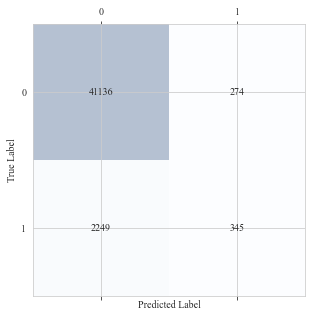

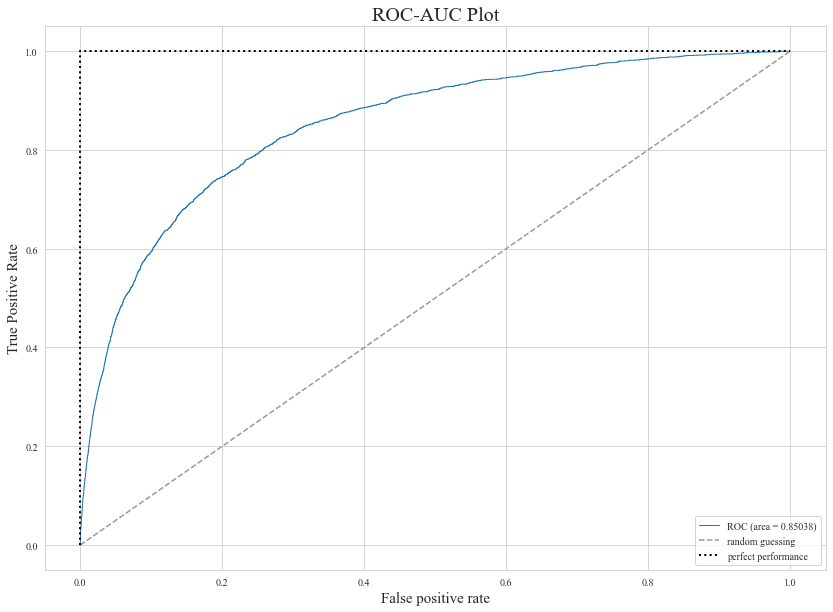

In [147]:
rfc=RandomForestClassifier(n_estimators=20, n_jobs=-1, max_depth=16, min_samples_leaf=10)
rfc.fit(X_training,y_training)
print('Training accuracy:', rfc.score(X_training, y_training))
print('Test accuracy:', rfc.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,rfc.predict(X_validation)))
confusion(X_validation, rfc)
AUC_ROC(X_validation,rfc)

### 极端随机森林.
极端随机森林因为随机选择的特性, 会比随机森林有着更好的泛化能力. 由于过拟合的威胁, 我们很自然地会尝试一下极端随机森林做法. 首先是不进行剪枝的极端随机森林

Training accuracy: 0.9998186133770043
Test accuracy: 0.9387328424688665
Test F1: 0.30551262235960847


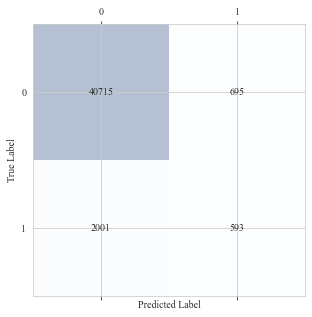

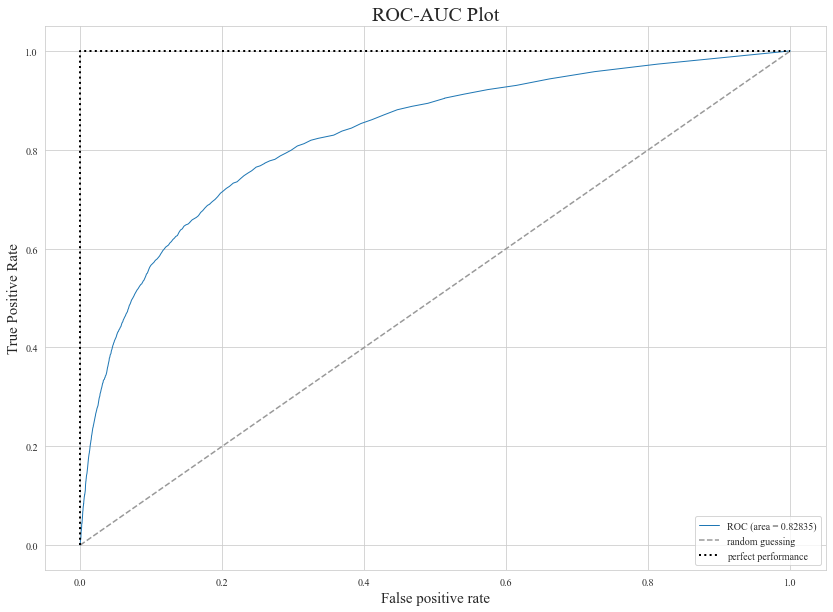

In [21]:
erfc=ExtraTreesClassifier(n_estimators=500, n_jobs=-1)
erfc.fit(X_training,y_training)
print('Training accuracy:', erfc.score(X_training, y_training))
print('Test accuracy:', erfc.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,erfc.predict(X_validation)))
confusion(X_validation, erfc)
AUC_ROC(X_validation,erfc)

与随机森林算法相同, 不剪枝的极端随机森林有着比较大的过拟合的风险, 我们还是进行一定的剪枝操作. 考虑到极端随机森林的一个特性是随机, 因此对剪枝可以进行一定的放松. 我们仍然不搜索超参数, 而直接指定. 设最大深度为10, min_sample_leaf为8

Training accuracy: 0.9639766166730583
Test accuracy: 0.9265748568311971
Test F1: 0.4102938492425625


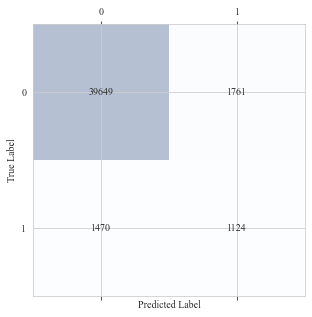

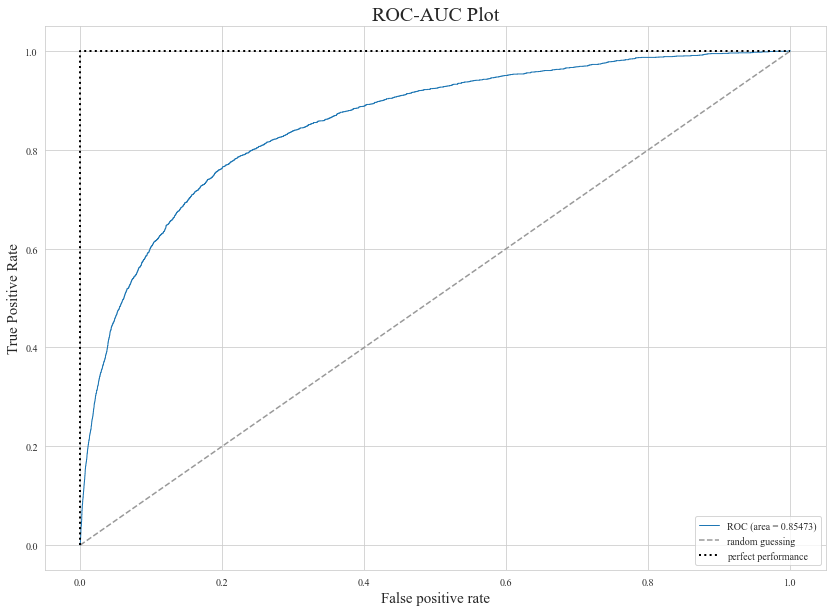

In [25]:
erfc=ExtraTreesClassifier(n_estimators=500, n_jobs=-1, max_depth=20, min_samples_leaf=8)
erfc.fit(X_training,y_training)
print('Training accuracy:', erfc.score(X_training, y_training))
print('Test accuracy:', erfc.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,erfc.predict(X_validation)))
confusion(X_validation, erfc)
AUC_ROC(X_validation,erfc)

### XGBoost Tree
XGBoost是一个典型的gradient boosting decision tree. 其效果一般非常好. 但是需要小心的是XGBoost会有很强的过拟合倾向

Training accuracy: 0.9691353215030095
Test accuracy: 0.9083719661848922
Test F1: 0.35280898876404493


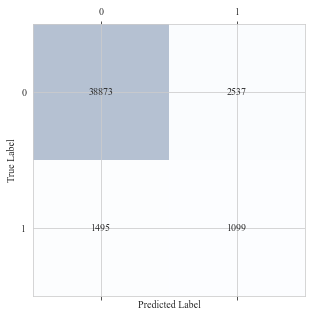

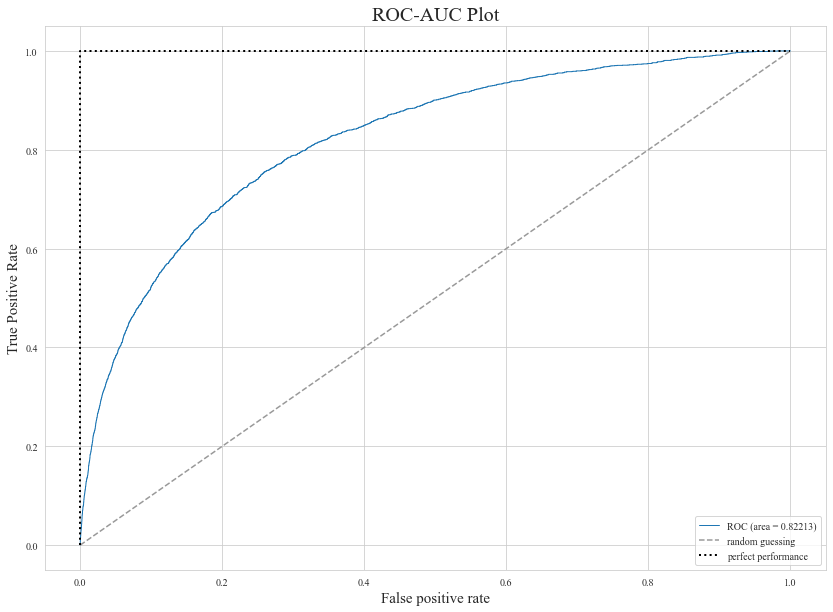

In [151]:
xgb=XGBClassifier(   eta=0.1,
                     colsample_bytree=0.5,
                     subsample=0.5,
                     max_depth=15,
                     min_child_weight=2,
                     scale_pos_weight=15
                    )
xgb.fit(X_training,y_training)
print('Training accuracy:', xgb.score(X_training, y_training))
print('Test accuracy:', xgb.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,xgb.predict(X_validation)))
confusion(X_validation, xgb)
AUC_ROC(X_validation,xgb)

我们这次需要来进行一定程度的调参, 我们不使用GridSearch而是自己计算并可视化

100%|██████████| 14/14 [00:37<00:00,  2.66s/it]


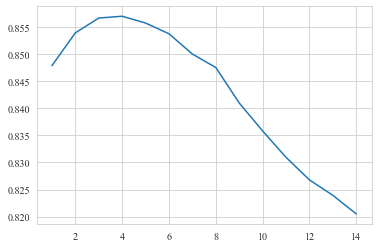

In [153]:
max_depth=np.arange(1,15,1)
res=[]
for depth in tqdm(max_depth):
    xgb=XGBClassifier(   eta=0.1,
                     colsample_bytree=0.5,
                     subsample=0.5,
                     max_depth=depth,
                     min_child_weight=2,
                     scale_pos_weight=15
                    )
    xgb.fit(X_training,y_training)
    res.append(roc_auc_score(y_validation, xgb.predict_proba(X_validation)[:,1]) )
plt.plot(max_depth, res)

很明显, 在depth=4时有一个比较好的峰值, 因此我们可以取max_depth=4

100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


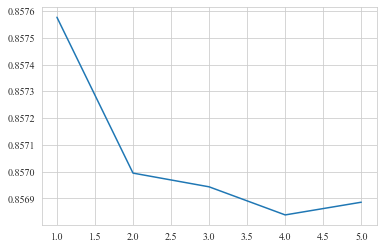

In [154]:
weights=np.arange(1,6,1)
res=[]
for weight in tqdm(weights):
    xgb=XGBClassifier(   eta=0.1,
                     colsample_bytree=0.5,
                     subsample=0.5,
                     max_depth=4,
                     min_child_weight=weight,
                    scale_pos_weight=15
                    )
    xgb.fit(X_training,y_training)
    res.append(roc_auc_score(y_validation, xgb.predict_proba(X_validation)[:,1]) )
plt.plot(weights, res)

这里呈现出了比较明显的下降的趋势, 因此我们有充分的动机选择1作为超参数

下面给出了调参过后的模型的结果

Training accuracy: 0.7942322301653778
Test accuracy: 0.7910189982728842
Test F1: 0.3018524142119648


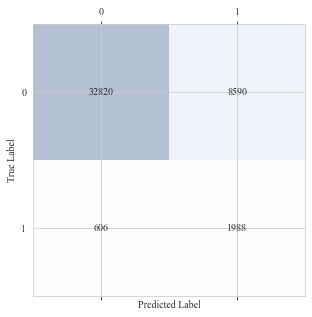

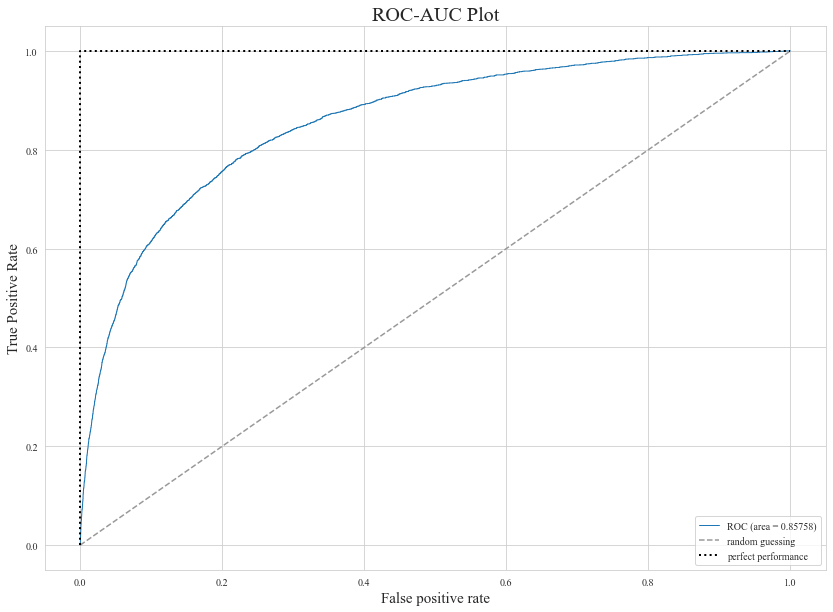

Training accuracy: 0.7942322301653778
Test accuracy: 0.7910189982728842
Test F1: 0.3018524142119648


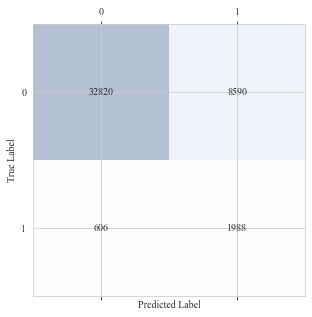

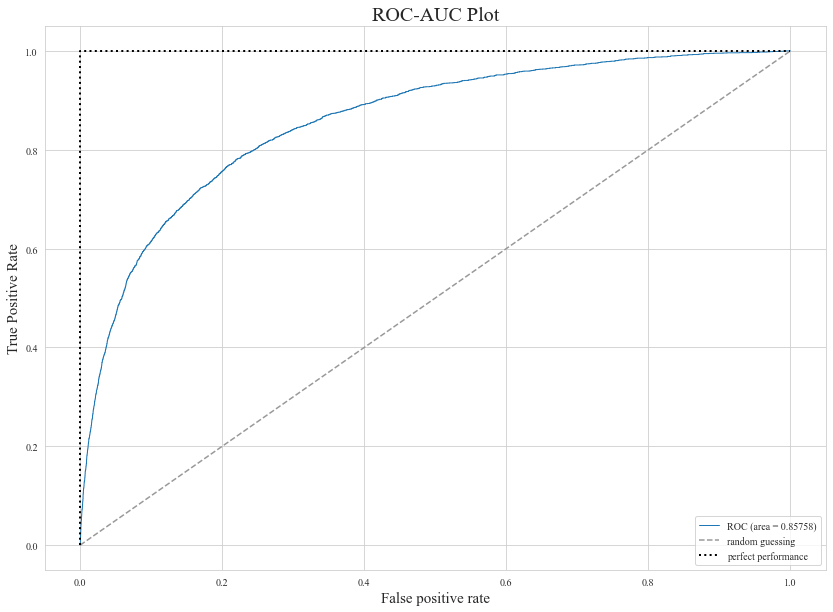

In [159]:
xgb=XGBClassifier(   eta=0.1,
                     colsample_bytree=0.5,
                     subsample=0.5,
                     max_depth=4,
                     min_child_weight=1,
                     scale_pos_weight=15
                    )
xgb.fit(X_training,y_training)
print('Training accuracy:', xgb.score(X_training, y_training))
print('Test accuracy:', xgb.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,xgb.predict(X_validation)))
confusion(X_validation, xgb)
AUC_ROC(X_validation,xgb)

## 集成

In [129]:
clf1=LogisticRegression()
clf2=RandomForestClassifier(n_estimators=500, n_jobs=-1, max_depth=16, min_samples_leaf=10)
clf3=ExtraTreesClassifier(n_estimators=500, n_jobs=-1, max_depth=20, min_samples_leaf=8)
clf4=XGBClassifier(   eta=0.1,
                     colsample_bytree=0.5,
                     subsample=0.5,
                     max_depth=6,
                     min_child_weight=3,
                    )
vclf=VotingClassifier(estimators=[('rf', clf2), ('erf', clf3), ('xgb', clf4)],voting="soft")
vclf = vclf.fit(X_training,y_training)

Training accuracy: 0.9716104022637051
Test accuracy: 0.9415280429051904
Test F1: 0.3209290050145157


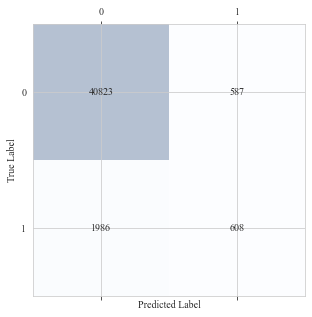

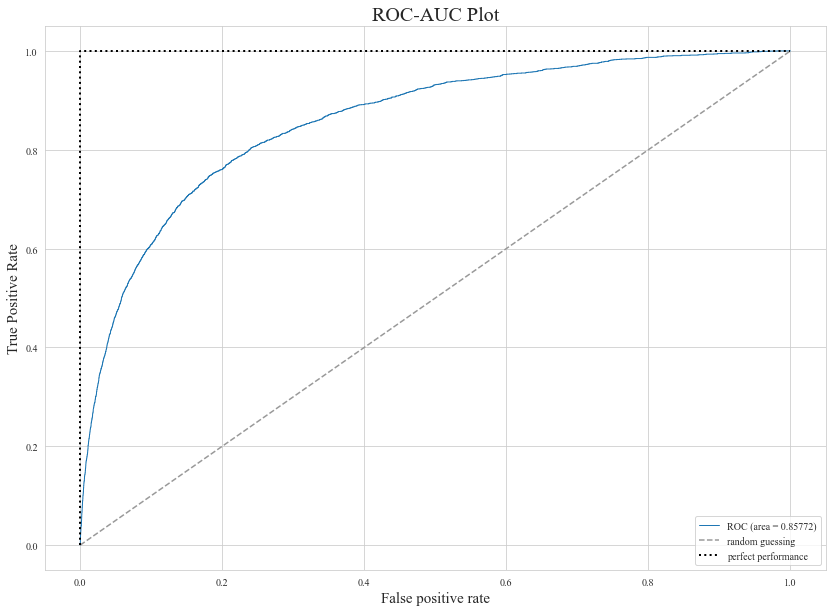

In [130]:
print('Training accuracy:', vclf.score(X_training, y_training))
print('Test accuracy:', vclf.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,vclf.predict(X_validation)))
confusion(X_validation, vclf)
AUC_ROC(X_validation,vclf)

In [133]:
res=vclf.predict_proba(X_test)[:,-1]


In [137]:
data=pd.read_csv(r"Dataset/sampleEntry.csv")
data["Probability"]=res
data.to_csv(r"Dataset/sampleEntry.csv")